In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, 
                             auc, RocCurveDisplay)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

data_frame = pd.read_csv('Gradients.csv')

#Separating sSFR gradients into the different categories

q_vals = data_frame['sSFR_grad'].quantile([0.34,0.665]).tolist()

data_frame.loc[(data_frame['sSFR_grad'] < q_vals[0]) , 'sSFR_gradient'] = int(0)

data_frame.loc[(data_frame['sSFR_grad'] > q_vals[0]) & (data_frame['sSFR_gradient'] < q_vals[1]) , 'density_grad'] = int(1)

data_frame.loc[(data_frame['sSFR_grad'] > q_vals[1]) , 'sSFR_gradient'] = int(2)

def random_forest(data, column, test_size=0.2, random_state=50, n_classes=3):
    """
    Trains a Random Forest classifier on the provided data and evaluates it.

    Parameters:
    - data: DataFrame containing the feature data and target variable.
    - column: The name of the target variable column.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.
    - n_classes: Number of unique classes in the target variable.

    Returns:
    - None
    """

    
    df = data.dropna()  
    X = df.drop(columns=[column]) #column is the gradient to predict
    y = df[column]

    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    # Hyperparameter tuning with GridSearchCV
    RF_parameters = {
        'max_depth': [5, 10, 15, 20], 
    'min_samples_leaf': [1, 3],          
    'min_samples_split': [2, 3, 4],     
    'n_estimators': [50, 100, 200] 
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(),
        param_grid=RF_parameters,
        scoring='accuracy',
        n_jobs=5,
        cv=5,
        verbose=True
    )

    
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    

   
    joblib.dump(model, 'random_forest_best_estimator.joblib')

    # Predict and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("The accuracy of the model is: ", accuracy)

    # Feature importance
    plot_feature_importance(model, X_train)

    # Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)

    # ROC Curve
    plot_roc_curve(model, X_train, y_train, X_test, y_test, n_classes)

def plot_feature_importance(model, X_train):
    """
    Plots feature importance of the model.

    Parameters:
    - model: Trained Random Forest model.
    - X_train: Training feature set.
    """
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    axes = sns.barplot(x=feature_importances, y=feature_importances.index, palette='crest', hue=feature_importances.index, legend=False)
    plt.xlabel('Feature Importance Score', fontsize=15)
    plt.ylabel('Features', fontsize=15)
    plt.title("Important Features", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    for spine in axes.spines.values():
        spine.set_linewidth(1.5)

    plt.show()
    plt.close()

def plot_confusion_matrix(model, X_test, y_test):
    """
    Plots the confusion matrix of the model predictions.

    Parameters:
    - model: Trained Random Forest model.
    - X_test: Testing feature set.
    - y_test: Testing target values.
    """
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="RdPu")

def plot_roc_curve(model, X_train, y_train, X_test, y_test, n_classes):
    """
    Plots the ROC curve for the model.

    Parameters:
    - model: Trained Random Forest model.
    - X_train: Training feature set.
    - y_train: Training target values.
    - X_test: Testing feature set.
    - y_test: Testing target values.
    - n_classes: Number of unique classes.
    """
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC Curve
    fig1, ax = plt.subplots(figsize=(7, 7))
    colors = cycle(["#0D47A1", "#E65100", "#4CAF50"])

    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for class {class_id}",
            color=color,
            ax=ax,
        )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve "
    )
    plt.xlim(-0.01, 1)
    plt.ylim(-0.01, 1.015)
    plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits
The accuracy of the model is:  0.6305882352941177


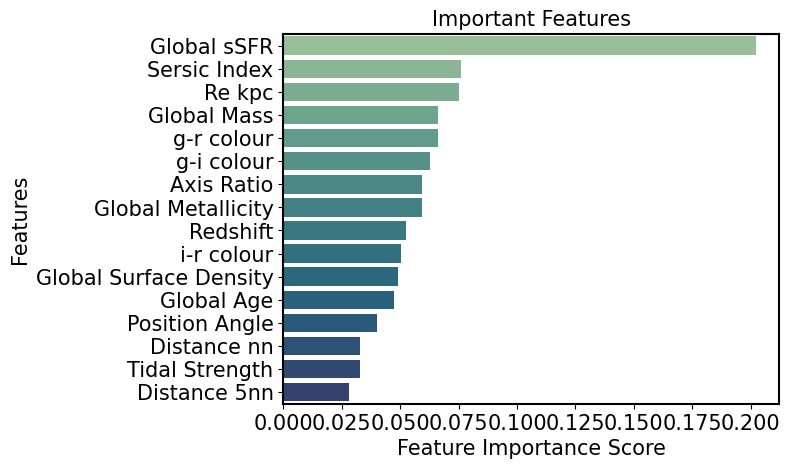

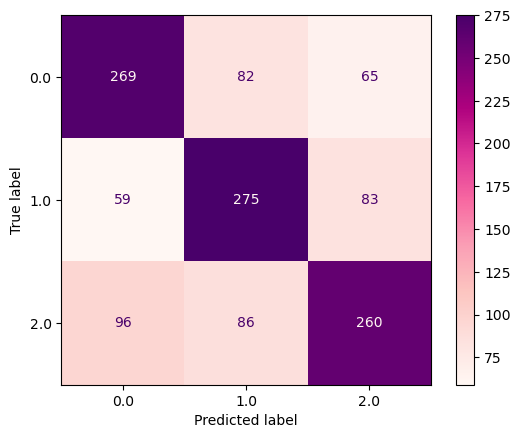

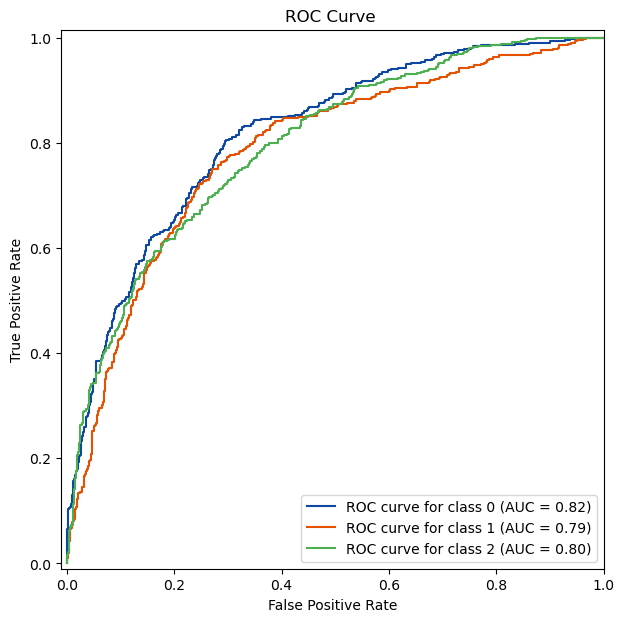

In [2]:
random_forest(data_frame, 'sSFR_gradient')